In [1]:

!pip install xgboost scikit-learn pandas matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier, plot_importance


In [5]:
# Titanic dataset from seaborn
titanic = sns.load_dataset("titanic")

# Display first rows
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


**Data Preprocessing & Feature Engineering**

In [6]:
# Drop irrelevant columns
titanic = titanic.drop(["deck", "embark_town", "alive", "class", "who", "adult_male"], axis=1)

# Handle missing values
titanic['age'].fillna(titanic['age'].median(), inplace=True)
titanic['embarked'].fillna(titanic['embarked'].mode()[0], inplace=True)

# Encode categorical features
titanic = pd.get_dummies(titanic, drop_first=True)

# Features (X) and Target (y)
X = titanic.drop("survived", axis=1)
y = titanic["survived"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


/tmp/ipython-input-2098335571.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)
/tmp/ipython-input-2098335571.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

**Train Initial XGBoost Model**

In [7]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print("Initial Accuracy:", accuracy_score(y_test, y_pred))


Initial Accuracy: 0.8044692737430168


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Hyperparameter Tuning (GridSearchCV)**

In [8]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
                           param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:57:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Evaluate the Best Model**

Tuned Model Accuracy: 0.8044692737430168

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       110
           1       0.80      0.65      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



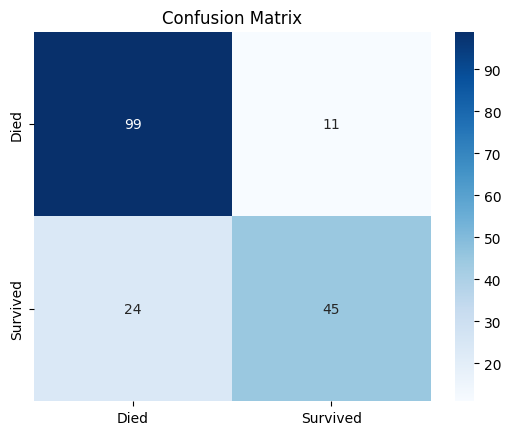

In [9]:
y_pred_best = best_model.predict(X_test)

print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Died", "Survived"], yticklabels=["Died", "Survived"])
plt.title("Confusion Matrix")
plt.show()


<Figure size 1000x600 with 0 Axes>

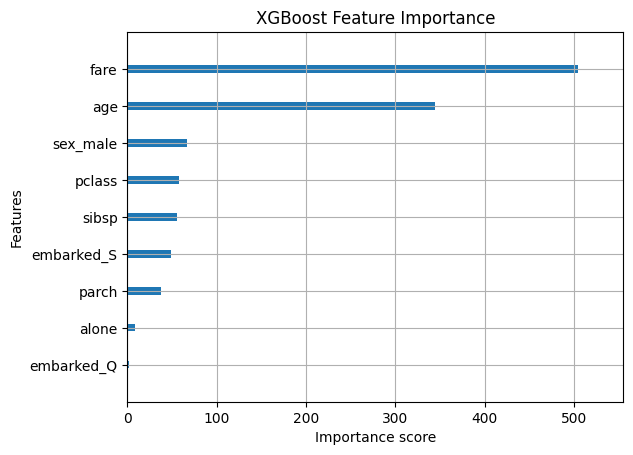

In [10]:
plt.figure(figsize=(10,6))
plot_importance(best_model, importance_type="weight", show_values=False)
plt.title("XGBoost Feature Importance")
plt.show()


**Model Learning Curve (Checking Performance Over Trees)**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:02:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


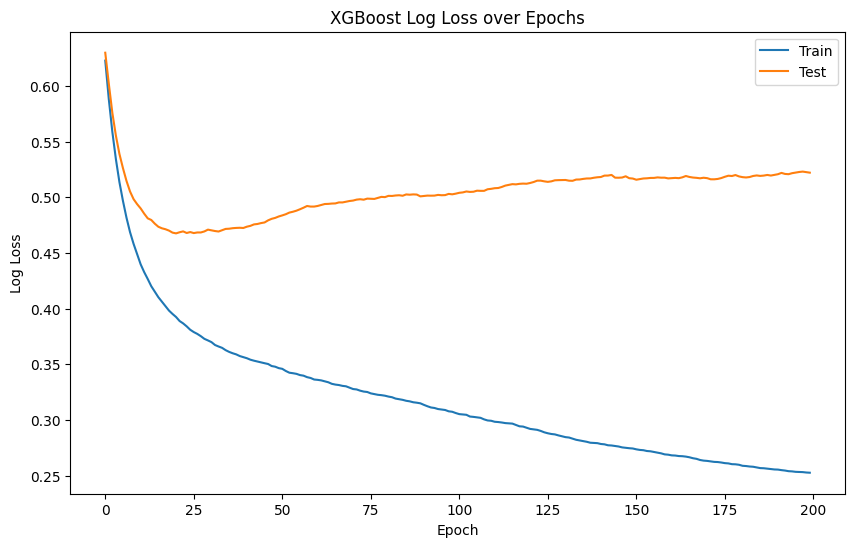

In [13]:
# Recreate the best_model with eval_metric inside constructor
best_model = XGBClassifier(
    **grid_search.best_params_,
    use_label_encoder=False,
    eval_metric="logloss",   # put it here, not in fit()
    random_state=42
)

# Train with evaluation sets
best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Get evaluation results
results = best_model.evals_result()

# Plot logloss curves
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10,6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.legend()
plt.title('XGBoost Log Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.show()


**Install & Import SHAP**

In [14]:
!pip install shap


In [15]:
import shap

# Initialize JavaScript for interactive plots
shap.initjs()


**Create SHAP Explainer**

In [16]:

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)


**SHAP Summary Plot (Global Feature Importance)**

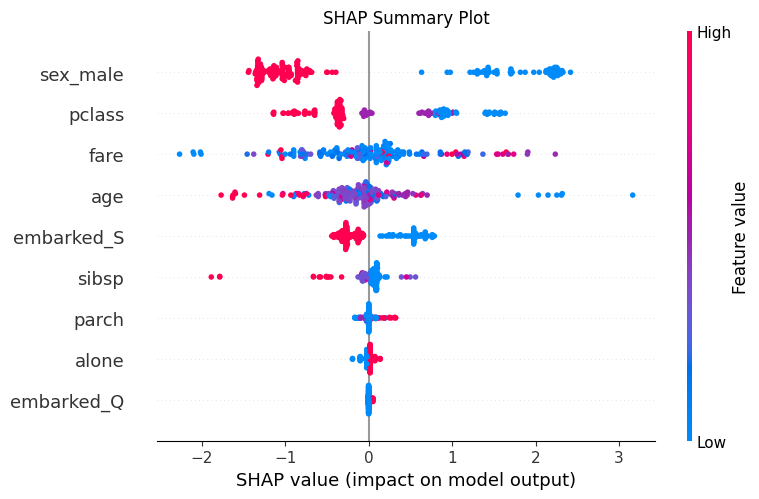

In [17]:
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test)


**SHAP Bar Plot (Mean Feature Impact)**

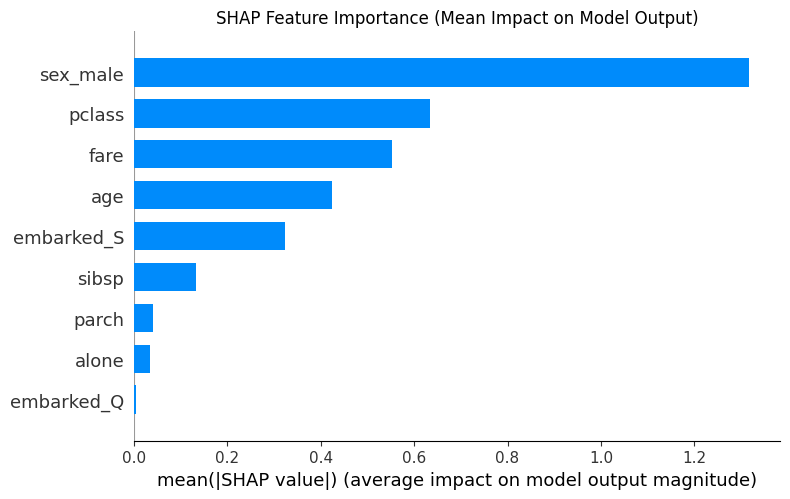

In [18]:
plt.title("SHAP Feature Importance (Mean Impact on Model Output)")
shap.summary_plot(shap_values, X_test, plot_type="bar")


**SHAP Dependence Plot (Feature Interaction)**

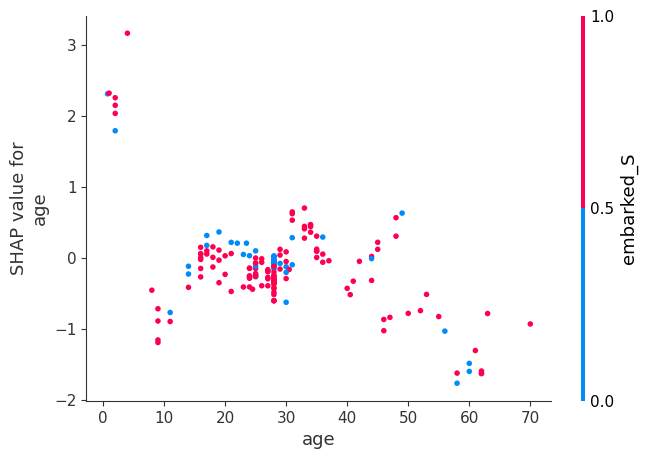

In [20]:
# Example: Age vs SHAP impact
shap.dependence_plot("age", shap_values, X_test)


**Cross-Validation with XGBoost**

Instead of just one train-test split, use Stratified K-Fold cross-validation.

In [21]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X, y, cv=kfold, scoring='accuracy')

print("Cross-Validation Accuracies:", scores)
print("Mean Accuracy:", scores.mean())


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:13:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:13:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:13:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:13:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:13:37] WARNING: /w

Cross-Validation Accuracies: [0.86592179 0.83707865 0.82022472 0.83146067 0.83146067]
Mean Accuracy: 0.8372293013621241


In [23]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


**Compare with Other Algorithms**

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": best_model
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.8045
Random Forest Accuracy: 0.8156
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8045


Logistic Regression Accuracy: 0.8045
Random Forest Accuracy: 0.8156
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:17:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-816695583.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=acc_df, palette="viridis")


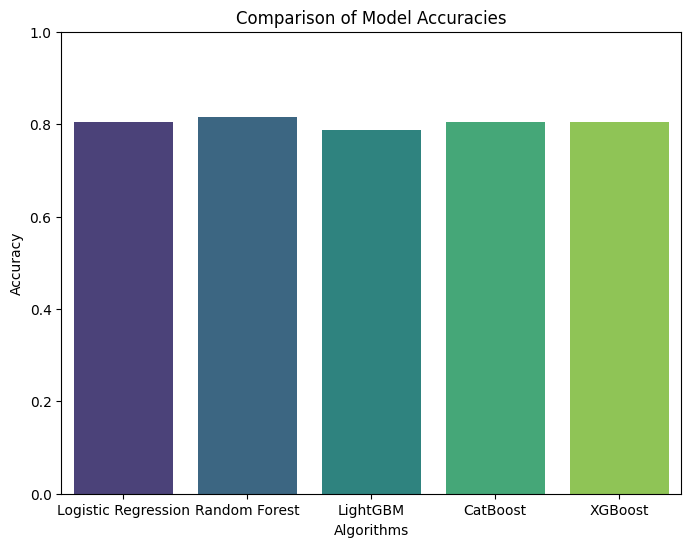

In [25]:
import matplotlib.pyplot as plt

# Dictionary to store accuracies
model_accuracies = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# Convert to DataFrame for easy plotting
acc_df = pd.DataFrame(list(model_accuracies.items()), columns=["Model", "Accuracy"])

# Plot accuracies
plt.figure(figsize=(8,6))
sns.barplot(x="Model", y="Accuracy", data=acc_df, palette="viridis")
plt.ylim(0,1)
plt.title("Comparison of Model Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
plt.show()


**Pipeline with Feature Engineering + Scaling**

Build a Scikit-Learn Pipeline (handles preprocessing + training in one go).

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # scaling (optional for XGBoost but good for others)
    ("xgb", best_model)
])

pipeline.fit(X_train, y_train)
print("Pipeline Accuracy:", pipeline.score(X_test, y_test))


Pipeline Accuracy: 0.8044692737430168


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:18:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Hyperparameter Tuning with Optuna**

Instead of GridSearchCV, show Optuna (Bayesian optimization) for tuning.

In [27]:
!pip install optuna




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.0 MB/s eta 0:00:00


In [28]:
import optuna

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "eval_metric": "logloss",
        "random_state": 42,
        "use_label_encoder": False
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Trial:", study.best_trial.params)

[I 2025-09-14 06:20:09,230] A new study created in memory with name: no-name-f6dfa187-e0a3-45a8-8c80-b6818b46ed7a
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:20:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-14 06:20:09,283] Trial 0 finished with value: 0.7932960893854749 and parameters: {'max_depth': 8, 'learning_rate': 0.01997246862121101, 'n_estimators': 84, 'subsample': 0.5247218582327082, 'colsample_bytree': 0.6171527245641859}. Best is trial 0 with value: 0.7932960893854749.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:20:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-14 06:20:09,362] Trial 1 finished with value: 0.7988826815642458 and parameters: {'max_depth': 3, 'learning_rate': 0.04429152629791636, 

Best Trial: {'max_depth': 5, 'learning_rate': 0.023060071042129628, 'n_estimators': 351, 'subsample': 0.8174044459121994, 'colsample_bytree': 0.5235195192729228}
